In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/test'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['age'].keys()))
print(len(subs))

830


In [2]:
import numpy as np

task = 'emoid'
x = []
y = []

for sub in subs:
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
    y.append(int(demo['age'][sub]))
#     y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(830, 34716)
(830,)
[116 187 190 242 137]


In [156]:
from sklearn.model_selection import train_test_split

import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class Basis(nn.Module):
    def __init__(self, dim):
        super(Basis, self).__init__()
        self.A = nn.Parameter(torch.randn(dim,264,2).float().cuda())
        
    def compute(self, dim=0):
        A = self.A[dim]#.unsqueeze(1)
        A = A@A.T
        a,b = torch.triu_indices(264,264,offset=1)
        return A[a,b]
    
    def to_img(self, dim=0):
        A = self.A[dim]#.unsqueeze(1)
        A = A@A.T
        return A.detach().cpu().numpy()
    
xtr, xt, ytr, yt = train_test_split(x, y, train_size=0.8)

xtr = torch.from_numpy(xtr).float().cuda()
xt = torch.from_numpy(xt).float().cuda()
ytr = torch.from_numpy(ytr).float().cuda()
yt = torch.from_numpy(yt).float().cuda()

mu = torch.mean(ytr)
ytr = ytr-mu
yt = yt-mu
    
w = nn.Parameter(torch.randn(1,len(ytr)).float().cuda())
u = nn.Parameter(torch.randn(1).float().cuda())
    
basis = Basis(100)
optim = torch.optim.Adam(basis.parameters(), lr=1e-1, weight_decay=0)

nepochs = 200
pperiod = 10
eye = torch.eye(1).float().cuda()

def rmse(a,b):
    return torch.mean((a-b)**2)**0.5

for n in range(basis.A.shape[0]):
    tgt = xtr
    cur = None
    print(f'Cur residual')
    with torch.no_grad():
        for m in range(n):
            A = basis.compute(m)
            A = A.unsqueeze(1).detach()
            w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-1*eye, A.T@tgt.T)
            xhat = (A@w).T
            tgt = tgt - xhat
            cur = cur + xhat if cur is not None else xhat
            print(float(rmse(cur, xtr)))
        print(f'Fitting {n}')
#     plt.imshow(vec2mat(tgt[0]))
#     plt.colorbar()
#     plt.show()
#     print(list(basis.A[0].detach().cpu().numpy()))
    for epoch in range(nepochs):
        optim.zero_grad()
        A = basis.compute(n)
        A = A.unsqueeze(1)
        w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-1*eye, A.T@tgt.T)
        xhat = (A@w).T
        rloss = rmse(tgt, xhat)
        rloss.backward()
        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs:
            print(f'{epoch} {float(rloss)}')
        
print('Complete')

Cur residual
Fitting 0
0 0.3916180431842804
10 0.3394434452056885
20 0.22948144376277924
30 0.20330823957920074
40 0.19971542060375214
50 0.1985670030117035
60 0.19803740084171295
70 0.19754144549369812
80 0.19684728980064392
90 0.1960274577140808
100 0.19535298645496368
110 0.19482192397117615
120 0.19442422688007355
130 0.19414575397968292
140 0.19394859671592712
150 0.19380980730056763
160 0.19371554255485535
170 0.19365422427654266
180 0.19361557066440582
190 0.19359178841114044
Cur residual
0.193577378988266
Fitting 1
0 0.19357578456401825
10 0.19281676411628723
20 0.1919984072446823
30 0.19175653159618378
40 0.1907004415988922
50 0.18944568932056427
60 0.18860502541065216
70 0.18799439072608948
80 0.18739986419677734
90 0.18687470257282257
100 0.1865922212600708
110 0.18649299442768097
120 0.1864624172449112
130 0.1864503026008606
140 0.1864432394504547
150 0.18643875420093536
160 0.1864357739686966
170 0.1864333301782608
180 0.1864309161901474
190 0.18642830848693848
Cur residua

40 0.16491734981536865
50 0.16490936279296875
60 0.1649055778980255
70 0.16490384936332703
80 0.16490286588668823
90 0.16490228474140167
100 0.16490191221237183
110 0.16490165889263153
120 0.1649014800786972
130 0.16490133106708527
140 0.1649012267589569
150 0.16490113735198975
160 0.16490106284618378
170 0.1649009883403778
180 0.16490094363689423
190 0.16490088403224945
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489443182945251
Fitting 14
0 0.16489166021347046
10 0.1642199158668518
20 0.1641715168952942
30 0.16416539251804352
40 0.1641623079776764
50 0.1641608476638794
60 0.16415908932685852
70 0.16415682435035706
80 0.1641537994146347
90 0.16414982080459595
100 0.16414450109004974
110 0.16413767635822296
120 0.1641300916671753
130 0.16412337124347687
140 0.164

10 0.15937548875808716
20 0.1593005657196045
30 0.1592802256345749
40 0.15927401185035706
50 0.15927116572856903
60 0.15926876664161682
70 0.1592661589384079
80 0.15926353633403778
90 0.15926142036914825
100 0.15925997495651245
110 0.15925906598567963
120 0.1592583954334259
130 0.15925772488117218
140 0.15925690531730652
150 0.1592559814453125
160 0.15925505757331848
170 0.15925423800945282
180 0.15925364196300507
190 0.15925325453281403
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.1641131043434143
0.16334545612335205
0.16274720430374146
0.1621895283460617
0.16171367466449738
0.16116076707839966
0.16061095893383026
0.16017436981201172
0.15968966484069824
0.15925318002700806
Fitting 24
0 0.15925195813179016
10 0.15899758040905
20 0.158917397260665

10 0.15612700581550598
20 0.1561037302017212
30 0.15609493851661682
40 0.15608204901218414
50 0.156063973903656
60 0.1560499668121338
70 0.15604037046432495
80 0.15603592991828918
90 0.15603387355804443
100 0.15603290498256683
110 0.1560325175523758
120 0.15603236854076385
130 0.1560322791337967
140 0.1560322493314743
150 0.15603220462799072
160 0.15603218972682953
170 0.15603217482566833
180 0.15603217482566833
190 0.15603217482566833
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.1641131043434143
0.16334545612335205
0.16274720430374146
0.1621895283460617
0.16171367466449738
0.16116076707839966
0.16061095893383026
0.16017436981201172
0.15968966484069824
0.1592530608177185
0.1587899774312973
0.1583719402551651
0.15796153247356415
0.1574907153844833

20 0.15368972718715668
30 0.15366068482398987
40 0.1536329984664917
50 0.15361201763153076
60 0.1535995453596115
70 0.15359142422676086
80 0.15358513593673706
90 0.15358060598373413
100 0.15357792377471924
110 0.15357641875743866
120 0.15357539057731628
130 0.153574600815773
140 0.15357385575771332
150 0.15357306599617004
160 0.15357211232185364
170 0.15357089042663574
180 0.15356925129890442
190 0.1535670906305313
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.1641131043434143
0.16334545612335205
0.16274720430374146
0.1621895283460617
0.16171367466449738
0.16116076707839966
0.16061095893383026
0.16017436981201172
0.15968966484069824
0.1592530608177185
0.1587899774312973
0.1583719402551651
0.15796153247356415
0.15749071538448334
0.1571016013622284


Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.1641131043434143
0.16334545612335205
0.16274720430374146
0.1621895283460617
0.16171367466449738
0.16116076707839966
0.16061095893383026
0.16017436981201172
0.15968966484069824
0.1592530608177185
0.1587899774312973
0.1583719402551651
0.15796153247356415
0.15749071538448334
0.1571016013622284
0.15675130486488342
0.15642522275447845
0.15603192150592804
0.15572573244571686
0.15522518754005432
0.1549024134874344
0.1545705646276474
0.15424203872680664
0.153909832239151
0.1535617858171463
0.15327753126621246
0.15295465290546417
0.15268713235855103
0.1524018496274948
0.15211030840873718
0.1518193781375885
Fitting 45
0 0.15181803703308105
10 0.15164494514465332
20 0.15160129964351654
30 0.151588574051857
40 0.1

70 0.15030702948570251
80 0.15030629932880402
90 0.15030577778816223
100 0.15030537545681
110 0.15030504763126373
120 0.15030476450920105
130 0.15030446648597717
140 0.15030419826507568
150 0.1503038853406906
160 0.15030354261398315
170 0.15030314028263092
180 0.1503027081489563
190 0.1503022313117981
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.1641131043434143
0.16334545612335205
0.16274720430374146
0.1621895283460617
0.16171367466449738
0.16116076707839966
0.16061095893383026
0.16017436981201172
0.15968966484069824
0.1592530608177185
0.1587899774312973
0.1583719402551651
0.15796153247356415
0.15749071538448334
0.1571016013622284
0.15675130486488342
0.15642522275447845
0.15603192150592804
0.15572573244571686
0.15522518754005432
0.15490241348743

0.15424203872680664
0.153909832239151
0.1535617858171463
0.15327753126621246
0.15295465290546417
0.15268713235855103
0.1524018496274948
0.15211030840873718
0.15181857347488403
0.15156885981559753
0.1513110250234604
0.15106305480003357
0.1508122831583023
0.15056106448173523
0.15030059218406677
0.15007512271404266
0.14982002973556519
0.14958353340625763
0.14935222268104553
0.14911141991615295
Fitting 56
0 0.1491091549396515
10 0.14894181489944458
20 0.14891758561134338
30 0.14891040325164795
40 0.14890556037425995
50 0.14890198409557343
60 0.1488998830318451
70 0.14889860153198242
80 0.14889760315418243
90 0.14889676868915558
100 0.1488959938287735
110 0.148895263671875
120 0.14889457821846008
130 0.14889390766620636
140 0.14889322221279144
150 0.14889246225357056
160 0.14889156818389893
170 0.1488903909921646
180 0.14888885617256165
190 0.14888693392276764
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.1

0.15056106448173523
0.15030059218406677
0.15007512271404266
0.14982002973556519
0.14958353340625763
0.14935222268104553
0.14911141991615295
0.14888285100460052
0.1486465483903885
0.14843964576721191
0.14814813435077667
0.1479271501302719
Fitting 61
0 0.14792503416538239
10 0.14778847992420197
20 0.14776179194450378
30 0.14774736762046814
40 0.1477392613887787
50 0.1477350890636444
60 0.1477319300174713
70 0.14772875607013702
80 0.14772455394268036
90 0.14771869778633118
100 0.14771205186843872
110 0.147707000374794
120 0.1477040946483612
130 0.14770248532295227
140 0.14770154654979706
150 0.1477009803056717
160 0.14770063757896423
170 0.14770041406154633
180 0.14770027995109558
190 0.14770017564296722
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.

0.15424203872680664
0.153909832239151
0.1535617858171463
0.15327753126621246
0.15295465290546417
0.15268713235855103
0.1524018496274948
0.15211030840873718
0.15181857347488403
0.15156885981559753
0.1513110250234604
0.15106305480003357
0.1508122831583023
0.15056106448173523
0.15030059218406677
0.15007512271404266
0.14982002973556519
0.14958353340625763
0.14935222268104553
0.14911141991615295
0.14888285100460052
0.1486465483903885
0.14843964576721191
0.14814813435077667
0.1479266881942749
0.147699773311615
0.14748860895633698
0.14728130400180817
0.14707784354686737
0.14686566591262817
Fitting 66
0 0.14686356484889984
10 0.14673534035682678
20 0.14671191573143005
30 0.1467045247554779
40 0.14670000970363617
50 0.14669612050056458
60 0.14669303596019745
70 0.14669053256511688
80 0.14668825268745422
90 0.14668601751327515
100 0.14668390154838562
110 0.14668214321136475
120 0.14668095111846924
130 0.14668025076389313
140 0.14667987823486328
150 0.14667966961860657
160 0.14667955040931702
170

120 0.14589913189411163
130 0.1458982527256012
140 0.14589759707450867
150 0.14589707553386688
160 0.14589671790599823
170 0.14589641988277435
180 0.14589619636535645
190 0.14589601755142212
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.1641131043434143
0.16334545612335205
0.16274720430374146
0.1621895283460617
0.16171367466449738
0.16116076707839966
0.16061095893383026
0.16017436981201172
0.15968966484069824
0.1592530608177185
0.1587899774312973
0.1583719402551651
0.15796153247356415
0.15749071538448334
0.1571016013622284
0.15675130486488342
0.15642522275447845
0.15603192150592804
0.15572573244571686
0.15522518754005432
0.1549024134874344
0.1545705646276474
0.15424203872680664
0.153909832239151
0.1535617858171463
0.15327753126621246
0.15295465290

0.15424203872680664
0.153909832239151
0.1535617858171463
0.15327753126621246
0.15295465290546417
0.15268713235855103
0.1524018496274948
0.15211030840873718
0.15181857347488403
0.15156885981559753
0.1513110250234604
0.15106305480003357
0.1508122831583023
0.15056106448173523
0.15030059218406677
0.15007512271404266
0.14982002973556519
0.14958353340625763
0.14935222268104553
0.14911141991615295
0.14888285100460052
0.1486465483903885
0.14843964576721191
0.14814813435077667
0.1479266881942749
0.147699773311615
0.14748860895633698
0.14728130400180817
0.14707784354686737
0.14686566591262817
0.14667925238609314
0.14649063348770142
0.14628706872463226
0.14608952403068542
0.14589574933052063
0.1457047164440155
0.14552687108516693
0.1453399807214737
0.1451495885848999
Fitting 75
0 0.1451464742422104
10 0.14502465724945068
20 0.14499741792678833
30 0.14498673379421234
40 0.14498230814933777
50 0.14498038589954376
60 0.14497964084148407
70 0.144979327917099
80 0.14497913420200348
90 0.14497900009155

0.1479266881942749
0.147699773311615
0.14748860895633698
0.14728130400180817
0.14707784354686737
0.14686566591262817
0.14667925238609314
0.14649063348770142
0.14628706872463226
0.14608952403068542
0.14589574933052063
0.1457047164440155
0.14552687108516693
0.1453399807214737
0.14514955878257751
0.14497780799865723
0.14479126036167145
0.14460626244544983
0.14442585408687592
Fitting 79
0 0.14442390203475952
10 0.14431552588939667
20 0.14428704977035522
30 0.14427624642848969
40 0.1442699432373047
50 0.14426535367965698
60 0.14426209032535553
70 0.14425970613956451
80 0.14425787329673767
90 0.1442563384771347
100 0.14425505697727203
110 0.14425401389598846
120 0.14425313472747803
130 0.14425233006477356
140 0.1442514955997467
150 0.1442505121231079
160 0.14424921572208405
170 0.14424745738506317
180 0.14424508810043335
190 0.14424224197864532
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964


0.1479266881942749
0.147699773311615
0.14748860895633698
0.14728130400180817
0.14707784354686737
0.14686566591262817
0.14667925238609314
0.14649063348770142
0.14628706872463226
0.14608952403068542
0.14589574933052063
0.1457047164440155
0.14552687108516693
0.1453399807214737
0.14514955878257751
0.14497780799865723
0.14479126036167145
0.14460626244544983
0.14442579448223114
0.14423756301403046
0.14405739307403564
0.14388351142406464
0.14372456073760986
Fitting 83
0 0.14372332394123077
10 0.14362919330596924
20 0.14359337091445923
30 0.14358343183994293
40 0.1435786336660385
50 0.14357545971870422
60 0.1435728520154953
70 0.14357058703899384
80 0.14356863498687744
90 0.14356712996959686
100 0.1435660868883133
110 0.14356541633605957
120 0.14356496930122375
130 0.14356468617916107
140 0.14356447756290436
150 0.14356432855129242
160 0.14356422424316406
170 0.1435641199350357
180 0.14356401562690735
190 0.14356394112110138
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516

0.15106305480003357
0.1508122831583023
0.15056106448173523
0.15030059218406677
0.15007512271404266
0.14982002973556519
0.14958353340625763
0.14935222268104553
0.14911141991615295
0.14888285100460052
0.1486465483903885
0.14843964576721191
0.14814813435077667
0.1479266881942749
0.147699773311615
0.14748860895633698
0.14728130400180817
0.14707784354686737
0.14686566591262817
0.14667925238609314
0.14649063348770142
0.14628706872463226
0.14608952403068542
0.14589574933052063
0.1457047164440155
0.14552687108516693
0.1453399807214737
0.14514955878257751
0.14497780799865723
0.14479126036167145
0.14460626244544983
0.14442579448223114
0.14423756301403046
0.14405739307403564
0.14388351142406464
0.1437244713306427
0.14356373250484467
0.14339850842952728
0.14322969317436218
0.14307273924350739
Fitting 87
0 0.1430693417787552
10 0.142948180437088
20 0.14293013513088226
30 0.14291968941688538
40 0.14291414618492126
50 0.14291183650493622
60 0.14291079342365265
70 0.14291034638881683
80 0.142910152673

0.1587899774312973
0.1583719402551651
0.15796153247356415
0.15749071538448334
0.1571016013622284
0.15675130486488342
0.15642522275447845
0.15603192150592804
0.15572573244571686
0.15522518754005432
0.1549024134874344
0.1545705646276474
0.15424203872680664
0.153909832239151
0.1535617858171463
0.15327753126621246
0.15295465290546417
0.15268713235855103
0.1524018496274948
0.15211030840873718
0.15181857347488403
0.15156885981559753
0.1513110250234604
0.15106305480003357
0.1508122831583023
0.15056106448173523
0.15030059218406677
0.15007512271404266
0.14982002973556519
0.14958353340625763
0.14935222268104553
0.14911141991615295
0.14888285100460052
0.1486465483903885
0.14843964576721191
0.14814813435077667
0.1479266881942749
0.147699773311615
0.14748860895633698
0.14728130400180817
0.14707784354686737
0.14686566591262817
0.14667925238609314
0.14649063348770142
0.14628706872463226
0.14608952403068542
0.14589574933052063
0.1457047164440155
0.14552687108516693
0.1453399807214737
0.145149558782577

20 0.14183472096920013
30 0.14182358980178833
40 0.141817107796669
50 0.14181232452392578
60 0.14180880784988403
70 0.14180640876293182
80 0.14180471003055573
90 0.14180348813533783
100 0.141802579164505
110 0.1418018937110901
120 0.14180132746696472
130 0.14180079102516174
140 0.14180025458335876
150 0.1417997181415558
160 0.1417991667985916
170 0.14179861545562744
180 0.14179804921150208
190 0.1417974978685379
Cur residual
0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.1641131043434143
0.16334545612335205
0.16274720430374146
0.1621895283460617
0.16171367466449738
0.16116076707839966
0.16061095893383026
0.16017436981201172
0.15968966484069824
0.1592530608177185
0.1587899774312973
0.1583719402551651
0.15796153247356415
0.15749071538448334
0.1571016013622284
0.1

0.15424203872680664
0.153909832239151
0.1535617858171463
0.15327753126621246
0.15295465290546417
0.15268713235855103
0.1524018496274948
0.15211030840873718
0.15181857347488403
0.15156885981559753
0.1513110250234604
0.15106305480003357
0.1508122831583023
0.15056106448173523
0.15030059218406677
0.15007512271404266
0.14982002973556519
0.14958353340625763
0.14935222268104553
0.14911141991615295
0.14888285100460052
0.1486465483903885
0.14843964576721191
0.14814813435077667
0.1479266881942749
0.147699773311615
0.14748860895633698
0.14728130400180817
0.14707784354686737
0.14686566591262817
0.14667925238609314
0.14649063348770142
0.14628706872463226
0.14608952403068542
0.14589574933052063
0.1457047164440155
0.14552687108516693
0.1453399807214737
0.14514955878257751
0.14497780799865723
0.14479126036167145
0.14460626244544983
0.14442579448223114
0.14423756301403046
0.14405739307403564
0.14388351142406464
0.1437244713306427
0.14356373250484467
0.14339850842952728
0.14322969317436218
0.14307267963

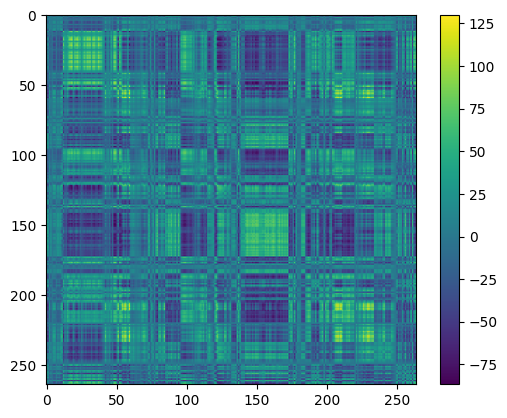

In [141]:
import matplotlib.pyplot as plt

def vec2mat(p):
    if isinstance(p, torch.Tensor):
        p = p.detach().cpu().numpy()
    m = np.zeros((264,264))
    a,b = np.triu_indices(264,1)
    m[a,b] = p
    return m+m.T

plt.imshow(basis.to_img(2))
# plt.imshow(vec2mat(tgt[0]))
plt.colorbar()
plt.show()

In [157]:
ws = []

with torch.no_grad():
    tgt = xtr
    cur = None
    for m in range(basis.A.shape[0]):
        A = basis.compute(m)
        A = A.unsqueeze(1).detach()
        w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-2*eye, A.T@tgt.T)
        ws.append(w)
        xhat = (A@w).T
        tgt = tgt - xhat
        cur = cur + xhat if cur is not None else xhat
        print(float(rmse(cur, xtr)))

print('Done')

ws = torch.cat(ws).T
u,_,_,_ = torch.linalg.lstsq(ws.T@ws+1e-6*torch.eye(ws.shape[1]).float().cuda(), ws.T@ytr)
yhat = ws@u
print(rmse(yhat,ytr))

ws = []

with torch.no_grad():
    tgt = xt
    cur = None
    for m in range(basis.A.shape[0]):
        A = basis.compute(m)
        A = A.unsqueeze(1).detach()
        w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-2*eye, A.T@tgt.T)
        ws.append(w)
        xhat = (A@w).T
        tgt = tgt - xhat
        cur = cur + xhat if cur is not None else xhat
        print(float(rmse(cur, xt)))
        
ws = torch.cat(ws).T
yhat = ws@u
print(rmse(yhat,yt))
print(rmse(ytr,torch.mean(ytr)))
print(rmse(yt,torch.mean(ytr)))

0.19356846809387207
0.18636512756347656
0.18172051012516022
0.17845329642295837
0.176004558801651
0.174375981092453
0.17234380543231964
0.1708541363477707
0.16953177750110626
0.16838786005973816
0.16746020317077637
0.16660691797733307
0.1657421737909317
0.16489438712596893
0.1641131043434143
0.16334545612335205
0.16274720430374146
0.1621895283460617
0.16171367466449738
0.16116076707839966
0.16061095893383026
0.16017436981201172
0.15968966484069824
0.1592530608177185
0.1587899774312973
0.1583719402551651
0.15796153247356415
0.15749071538448334
0.1571016013622284
0.15675130486488342
0.15642522275447845
0.15603192150592804
0.15572573244571686
0.15522518754005432
0.1549024134874344
0.1545705646276474
0.15424203872680664
0.153909832239151
0.1535617858171463
0.15327753126621246
0.15295465290546417
0.15268713235855103
0.1524018496274948
0.15211030840873718
0.15181857347488403
0.15156885981559753
0.1513110250234604
0.15106305480003357
0.1508122831583023
0.15056106448173523
0.15030059218406677
